# Monte Carlo Methods

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, rgamma
from scipy import integrate
import time

### Monte Carlo Integration

We are going to explore calculating the volume of a sphere in $d$ dimensions of radius 1. We know the answer analytically 

$$ V_d = \frac{\pi^{d/2}}{ \Gamma[\frac{d}{2}+1]}$$

As discussed, as $d$ in increases, this is a tiny fraction of the d-dimensional box that encloses the sphere, which has volume $2^d$

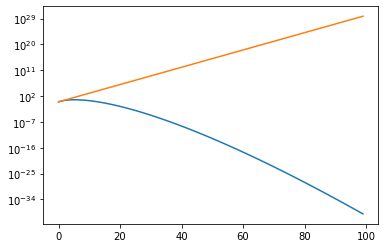

In [2]:
dlist=np.arange(100)
plt.plot(dlist,np.pi**(dlist/2.)/gamma(dlist/2.+1.))
plt.plot(dlist,2.**(dlist))
plt.yscale('log')

We can calculate the ratio of these volumes for a few values of $d$

In [3]:
def V_ratio(d):
    return np.pi**(d/2.)/(2**(d)*gamma(d/2.+1.))
print(V_ratio(3),V_ratio(10),V_ratio(20),V_ratio(100))

0.5235987755982989 0.00249039457019272 2.461136950494199e-08 1.8681820538375912e-70


We can caculate this using our basic Monte Carlo technique relatively easily

In [4]:
def dvol_fast(n,d):
    analytic=np.pi**(float(d)/2.)*rgamma(float(d)/2.+1)
    X=(2*np.random.rand(d*n)-1).reshape(n,d) # generate nxd random [-1,1]
    Y=((X**2).sum(axis=1)) # calculate x_1^2 +.. +x_d^2
    area=2**d*(Y<=1).sum()/n # add up all the points inside the sphere
    return area, (area-analytic)/analytic

The key idea is that we want to use numpy to do all the work for us. We organize all the random numbers we need into a single array and then add up the rows first, then impose the requirement that each row lives inside the circle, then we sum the answer.

In [5]:
dvol_fast(int(1e7),2)

(3.1413664, -7.201875441575515e-05)

We can get pretty decent accuracy for a pretty fast integral

In [6]:
t0 = time.time()
a2,e2=dvol_fast(int(1e7),2)
t1= time.time()
print(t1-t0)
print(a2,e2)

0.43084073066711426
3.1414584 -4.273424488685246e-05


In general, we expect the speed to scale like $n \times d$

In [7]:
t0 = time.time()
a10,e10=dvol_fast(int(1e7),10)
t1= time.time()
print(t1-t0)
print(a10,e10)

1.7297279834747314
2.5307136 -0.007627132832710121


The error should decrease like $1/\sqrt{N}$, at least until we start hitting the limits of our algorithm.

In [8]:
print(dvol_fast(int(1e4),2))
print(dvol_fast(int(1e6),2))
print(dvol_fast(int(1e8),2))

(3.1668, 0.008023747566828287)
(3.139028, -0.0008163545922678487)
(3.14126568, -0.0001040789261521331)


### Importance Sampling

Now we are going to improve our MC integration by drawing numbers from a Gaussian distribution. We are now not just adding up all the numbers inside the circle, but weighting them by $e^{-(\vec x^2)/2\sigma^2} \sqrt{2\pi \sigma^2}^d$

In [9]:
# We are going to pick from a gaussian distribution with some variance
def gaussvol_fast(n,d,sigma):
    analytic=np.pi**(float(d)/2.)*rgamma(float(d)/2.+1)
    count = 0
    Narea=[]
    X=(np.random.randn(d*n)*sigma).reshape(n,d)
    Y=((X**2).sum(axis=1))
    area=((Y<=1)*np.exp(Y/(2*sigma**2))).sum()*np.sqrt(2*np.pi*sigma**2)**d/n
    #return ((Y<=1)*np.exp(Y)).sum()/n
    return area,(area-analytic)/analytic

For low dimensions, this behaves about the same as our uniform distribution

In [10]:
print(dvol_fast(int(1e6),2))
print(gaussvol_fast(int(1e6),2,1))

(3.140836, -0.00024085031804754506)
(3.1446779212067626, 0.0009820711840040897)


We can also see how it depends on the choice of $\sigma$.

In [11]:
# We are going to pick from a gaussian distribution with some variance
def gaussvol_frac(n,d,sigma):
    analytic=np.pi**(float(d)/2.)*rgamma(float(d)/2.+1)
    count = 0
    Narea=[]
    X=(np.random.randn(d*n)*sigma).reshape(n,d)
    Y=((X**2).sum(axis=1))

    out_Vol=np.abs(((Y<=1)*np.exp(Y/(2*sigma**2))).sum()*np.sqrt(2*np.pi*sigma**2)**d/(n)-analytic)/analytic
    out_frac=(Y<=1).sum()/n
    return out_Vol,out_frac

In [21]:
npoints=1000000
dim=int(6)
s_r=np.logspace(-2,0.5,100)
error=np.zeros(len(s_r))
frac=np.zeros(len(s_r))
for i in range(len(s_r)):
    error[i],frac[i]=gaussvol_frac(npoints,dim,s_r[i])

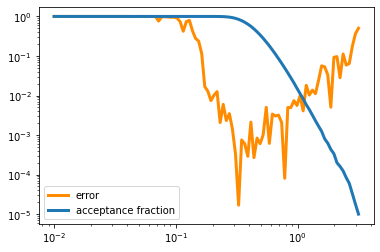

In [22]:
plt.plot(s_r,error,color='darkorange',lw=3,label='error')
plt.plot(s_r,frac,lw=3,label='acceptance fraction')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

We see that our error rises on both ends where the acceptance ratio is too large and too small. There is no perfect rule of thumb for where we get the best errors, as a pretty wide acceptance ratios still give good performance. We can see that error is at its lowest as the acceptance ratio starts to dip, indicating that our choice of $\sigma$ is just large enough to see the edge of the sphere.

The real benefit of importance sampling can be seen as we increase the dimension of the sphere.

In [23]:
print(dvol_fast(int(1e7),10))
print(gaussvol_fast(int(1e7),10,0.3))

(2.5833472, 0.013012166905251664)
(2.550643357295931, 0.00018795552407249535)


In [24]:
print(dvol_fast(int(1e7),15))
print(gaussvol_fast(int(1e7),15,0.3))

(0.4685824, 0.22844580979016124)
(0.3812614891730897, -0.0004765889435049658)


In [25]:
print(dvol_fast(int(1e7),18))
print(gaussvol_fast(int(1e7),18,0.3))

(0.0524288, -0.36175988642993684)
(0.08212992097112795, -0.00019435714506112672)


In [26]:
print(dvol_fast(int(1e7),20))
print(gaussvol_fast(int(1e7),20,0.3))

(0.0, -1.0)
(0.025794293953971, -0.00048814232805749957)


At $d=20$ and $N$ = 10 million, we the uniform sample completely fails to calculate the volume (not a single point was inside the sphere). By comparison, our Gaussian importance sampled calculating still gives an accurate result to 4 decimal places.